# Import

In [49]:
%load_ext autoreload
%autoreload 2
import re
import ast
import numpy as np
import json
import seaborn as sns
from scipy import stats
%matplotlib inline
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# CMU DATASET ANALYSIS

In [76]:
DATA_FOLDER = './datasets/'

In [77]:
# Loading characters
columns_char = ['Wikipedia_Movie_ID', 'Freebase_Movie_ID', 'Character_Name', 'Actor_DOB',
                'Actor_gender', 'Actor_height', 'Actor_ethnicity', 'Actor_Name',
                'Actor_age_at_movie_release', 'Freebase_character_map']

characters = pd.read_table(DATA_FOLDER+'CMU_dataset/character.metadata.tsv', names=columns_char,
                           usecols=[0, 1, 3, 4, 5, 6, 7, 8, 9, 10])

# Loading movies
columns_mov = ['Wikipedia_Movie_ID','Freebase_Movie_ID','Movie_name','Movie_release_date',
          'Movie_box_office_revenue', 'Movie_runtime', 'Movie_languages', 'Movie_countries',
          'Movie_genres']

cmu_df = pd.read_table(DATA_FOLDER+'CMU_dataset/movie.metadata.tsv', names=columns_mov, skipinitialspace=True)

The goal of our study is to analyze what factors contribute to the success of a movie. Let us first have a quick analysis on our provided data set.


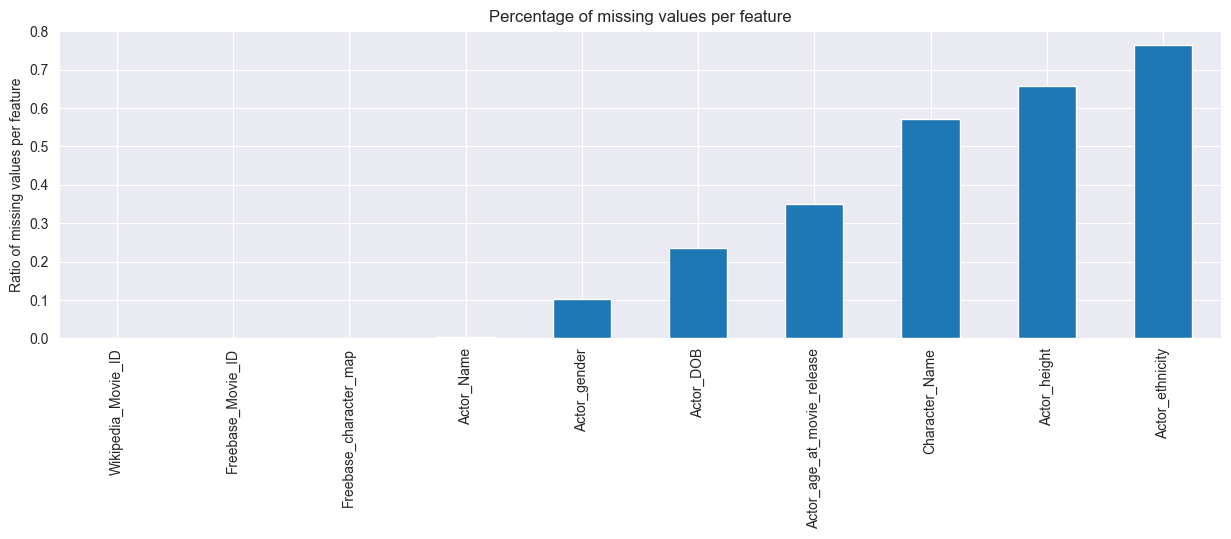

In [78]:
plot_missing_values_percentage(characters)

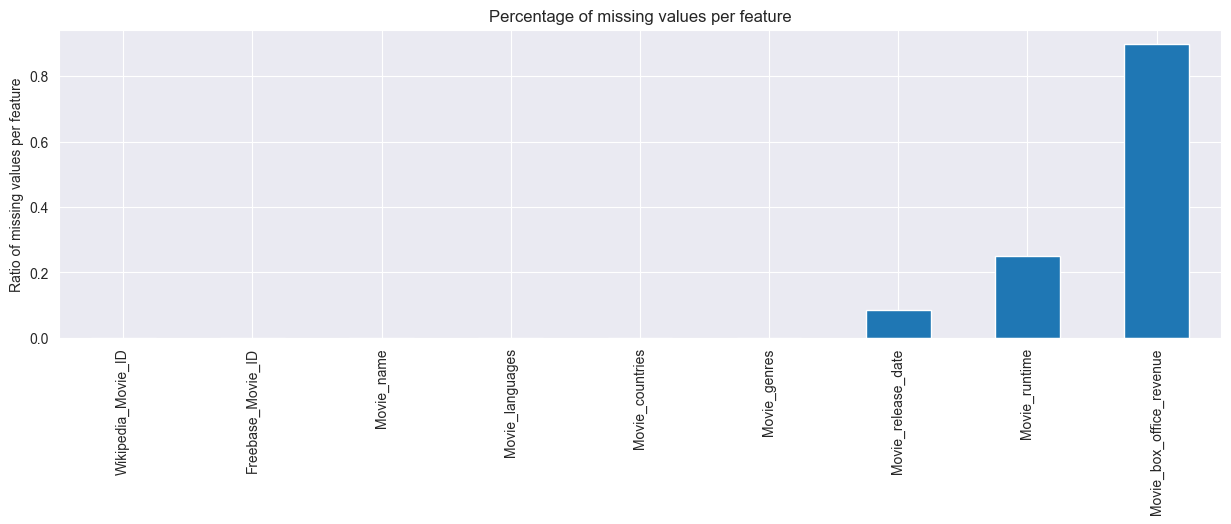

In [79]:
plot_missing_values_percentage(cmu_df)

**Comment:** Good factors to measure the success of a movie are its ratings and its revenues. We can see that our data set does not contain any information on movie ratings, and has a very high percentage of missing values for the movie revenues.
**Solution:** Merge the CMU dataset with our additional dataset that contains ratings informations and additional box office revenues

### Creating a mapping between the IMDB Id and the Freebase_Movie_ID

In [80]:
data = query_wikidata()

In [81]:
imbd_freebase = json_to_df(data)

In [82]:
imbd_freebase.drop_duplicates(subset=['imdb_id','freebase_id'], inplace=True)

# 2. TMBD Analysis

In [83]:
pd_tmbd = pd.read_csv('./datasets/TMBD_Dataset/movies_metadata.csv')

/var/folders/v2/6cxx8khs0hs5nml1jx68qgk40000gn/T/ipykernel_31928/4053239051.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  pd_tmbd = pd.read_csv('./datasets/TMBD_Dataset/movies_metadata.csv')


### Drop Non-related Columns

In [84]:
pd_tmbd = pd_tmbd.drop(['adult', 'belongs_to_collection',  'homepage', 'original_title', 'overview', 'poster_path', 'status', 'tagline', 'video'], axis=1)

#### Evaluate the literal value to convert it to array

In [85]:
# Apply the function to the 'genre' column
pd_tmbd['genres'] = pd_tmbd['genres'].apply(lambda x: safe_literal_eval(x))

# Apply the function to the 'production_companies' column
pd_tmbd['production_companies'] = pd_tmbd['production_companies'].apply(lambda x: safe_literal_eval(x))

# Apply the function to the 'production_countries' column
pd_tmbd['production_countries'] = pd_tmbd['production_countries'].apply(lambda x: safe_literal_eval(x))

# Apply the function to the 'spoken_languages' column
pd_tmbd['spoken_languages'] = pd_tmbd['spoken_languages'].apply(lambda x: safe_literal_eval(x))

#### Convert the initial dictonnaries into array of items

In [86]:
# Apply the function to the 'genre' column
pd_tmbd['genres'] = pd_tmbd['genres'].apply(lambda x: get_names(x))

# Apply the function to the 'production_companies' column
pd_tmbd['production_companies'] = pd_tmbd['production_companies'].apply(lambda x: get_names(x))

# Apply the function to the 'production_countries' column
pd_tmbd['production_countries'] = pd_tmbd['production_countries'].apply(lambda x: get_names(x))

# Apply the function to the 'spoken_languages' column
pd_tmbd['spoken_languages'] = pd_tmbd['spoken_languages'].apply(lambda x: get_names(x))

### Merging the CMU and the TMDB Datasets

In [87]:
cmu_df = pd.merge(left=cmu_df, right=imbd_freebase, right_on='freebase_id', left_on='Freebase_Movie_ID', how='inner').drop(columns='freebase_id')

In [88]:
movies = pd.merge(right=cmu_df, left=pd_tmbd, on='imdb_id', how='inner').drop_duplicates(subset='imdb_id')

### Box Office Revenue Data Consolidation

In [89]:
movies['revenue'].replace(0.0, np.nan, inplace=True)
movies['Movie_box_office_revenue'].replace(0.0, np.nan, inplace=True)

In [90]:
movies['revenue'] = movies['revenue'].fillna(movies['Movie_box_office_revenue'])
movies['Movie_box_office_revenue'] = movies['Movie_box_office_revenue'].fillna(movies['revenue'])
movies.drop(columns='revenue', inplace=True)

### Preprocessing the genres, languages and countries columns

**Comment:** We have the columns mentioned above are represented as dictionaries with key freebase_id and values country names, genres and languages of the movie with id freebase_id, that's why we decided to retrieve the values and store them instead of having the dictionary representation

In [91]:
movies['Movie_genres'] = movies['Movie_genres'].apply(transform_row)
movies['Movie_countries'] = movies['Movie_countries'].apply(transform_row)
movies['Movie_languages'] = movies['Movie_languages'].apply(transform_row)

In [66]:
movies.drop(columns=['Wikipedia_Movie_ID', 'Freebase_Movie_ID','Movie_release_date', 'title', 'runtime', 'original_language', 'production_companies','id'], axis=1, inplace=True)